1. idea is to develop a model by training on  images and its binary ground truhts so that it can predict binary masks for unseen images.
2. Test its acccuracy for based on few given metrics on the test and validaton data sets.

what about the data?
1. we have train test and vals ground and original images

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

In [2]:
#connect with colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
# Define the path to your folder
folder_path = '/content/drive/My Drive/Data_ph1'

In [4]:
# List all files in the folder
file_list = os.listdir(folder_path)

In [5]:
# Loading the data

train_image_path = "/content/drive/MyDrive/Data_ph1/Train/ISIC2018_Task1-2_Training_Input"
train_mask_path = "/content/drive/MyDrive/Data_ph1/Train/ISIC2018_Task1_Training_GroundTruth"

val_image_path = "/content/drive/MyDrive/Data_ph1/val/ISIC2018_Task1-2_Validation_Input"
val_mask_path = "/content/drive/MyDrive/Data_ph1/val/ISIC2018_Task1_Validation_GroundTruth"

#test_image_path = "dataset/test/images/"
#test_mask_path = "/content/drive/MyDrive/Data_ph1/Test/ISIC2018_Task1_Test_GroundTruth"

In [6]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3

VALID_IMAGE_EXTENSIONS = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')

def load_data(image_dir, mask_dir):
    images = []
    masks = []
    for file_name in os.listdir(image_dir):
        # Check if the file is an image
        if file_name.lower().endswith(VALID_IMAGE_EXTENSIONS):
            image_id = file_name.split('.')[0]

            # Load image
            image = cv2.imread(os.path.join(image_dir, file_name))
            image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
            images.append(image)

            # Load mask
            mask_name = f"{image_id}_segmentation.png"
            if os.path.exists(os.path.join(mask_dir, mask_name)):
                mask = cv2.imread(os.path.join(mask_dir, mask_name), cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
                mask = mask / 255.0
                masks.append(mask)

    images = np.array(images)
    masks = np.expand_dims(np.array(masks), axis=-1)
    return images, masks

In [7]:
# loading data
X_train, y_train = load_data(train_image_path, train_mask_path)
X_val, y_val = load_data(val_image_path, val_mask_path)
#X_test, y_test = load_data(test_image_path, test_mask_path)

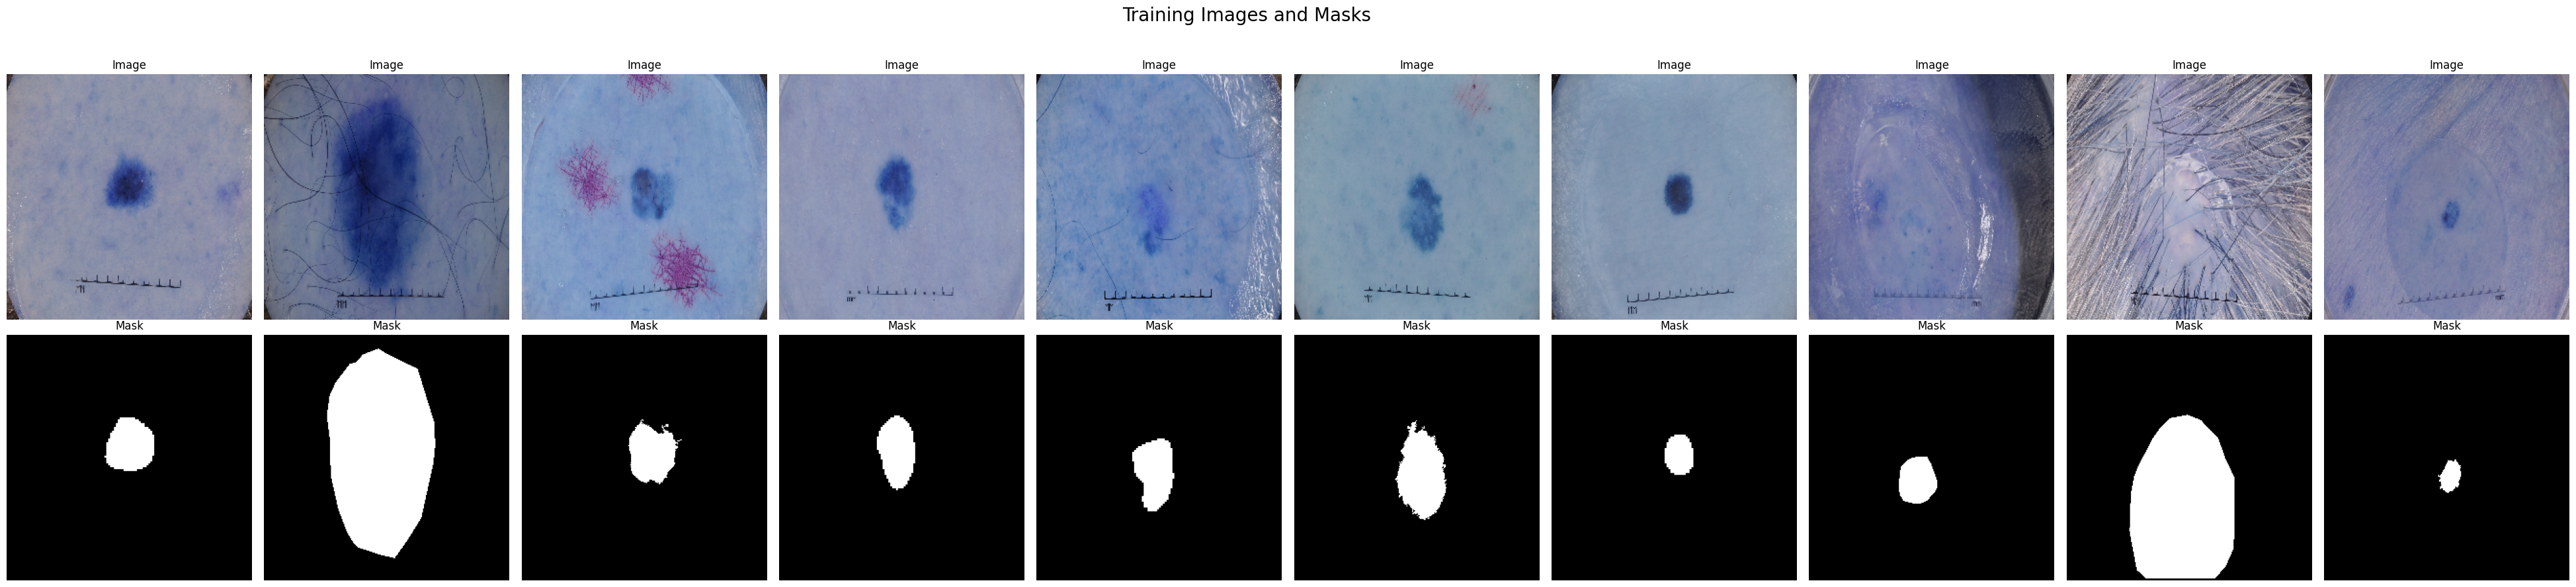

In [ ]:
import matplotlib.pyplot as plt

# Function to display images and their masks
def display_images_with_masks(images, masks, title=""):
    plt.figure(figsize=(50, 10))
    for i in range(10):
        # Display original image
        plt.subplot(2, 10, i + 1)
        plt.imshow(images[i].astype(np.uint8))
        plt.axis('off')
        plt.title("Image")

        # Display corresponding mask
        plt.subplot(2, 10, i + 11)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.axis('off')
        plt.title("Mask")

    plt.suptitle(title, fontsize=20)
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()

# Display 10 images and masks from the training set
display_images_with_masks(X_train, y_train, title="Training Images and Masks")


In [ ]:
def build_unet(input_shape):
    inputs = Input(input_shape)

    # Downsampling
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)

    # Upsampling
    u1 = UpSampling2D((2, 2))(c3)
    u1 = Concatenate()([u1, c2])
    c4 = Conv2D(32, (3, 3), activation='relu', padding='same')(u1)
    c4 = Conv2D(32, (3, 3), activation='relu', padding='same')(c4)

    u2 = UpSampling2D((2, 2))(c4)
    u2 = Concatenate()([u2, c1])
    c5 = Conv2D(16, (3, 3), activation='relu', padding='same')(u2)
    c5 = Conv2D(16, (3, 3), activation='relu', padding='same')(c5)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = Model(inputs, outputs)
    return model

model_unet = build_unet((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
model_unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_unet.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=100)

Epoch 1/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9040 - loss: 0.2404 - val_accuracy: 0.8799 - val_loss: 0.2917
Epoch 2/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8986 - loss: 0.2532 - val_accuracy: 0.8829 - val_loss: 0.2964
Epoch 3/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9057 - loss: 0.2364 - val_accuracy: 0.8915 - val_loss: 0.2725
Epoch 4/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8957 - loss: 0.2630 - val_accuracy: 0.8878 - val_loss: 0.2860
Epoch 5/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9045 - loss: 0.2405 - val_accuracy: 0.8909 - val_loss: 0.2717
Epoch 6/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9090 - loss: 0.2317 - val_accuracy: 0.8867 - val_loss: 0.2953
Epoch 7/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9003 - loss: 0.2534 - val_accuracy: 0.8945 - val_loss: 0.2691
Epoch 8/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9108 - loss: 0.2278 - 

In [ ]:
model_unet.evaluate(X_val, y_val)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8840 - loss: 0.2838


[0.29031825065612793, 0.8810281157493591]

In [9]:
# load model
from tensorflow.keras.models import load_model
model_unet = load_model('unet_model.h5')

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Concatenate
from tensorflow.keras.applications import ResNet50
def build_resnet_unet(input_shape):
    # Use ResNet50 as encoder
    resnet = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    resnet.trainable = False  # Freeze the ResNet layers to use pretrained features

    # Encoder layers (skip connections)
    encoder_output = resnet.get_layer("conv4_block6_out").output
    skip_connections = [
        resnet.get_layer("conv1_relu").output,
        resnet.get_layer("conv2_block3_out").output,
        resnet.get_layer("conv3_block4_out").output
    ]

    # Decoder
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(encoder_output)
    x = UpSampling2D((2, 2))(x)
    x = Concatenate()([x, skip_connections[2]])
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D((2, 2))(x)
    x = Concatenate()([x, skip_connections[1]])
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D((2, 2))(x)
    x = Concatenate()([x, skip_connections[0]])
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # Output layer for binary mask
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)

    # Build model
    model = Model(inputs=resnet.input, outputs=outputs)
    return model

model_renet50 = build_resnet_unet((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
model_renet50.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
history_resnet=model_renet50.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=100)
model_renet50.save('resnet50_model.h5')

Epoch 1/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 67ms/step - accuracy: 0.8100 - loss: 0.8425 - val_accuracy: 0.9136 - val_loss: 0.2121
Epoch 2/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9347 - loss: 0.1661 - val_accuracy: 0.9186 - val_loss: 0.2103
Epoch 3/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9336 - loss: 0.1708 - val_accuracy: 0.9243 - val_loss: 0.1830
Epoch 4/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9407 - loss: 0.1490 - val_accuracy: 0.9189 - val_loss: 0.1979
Epoch 5/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9421 - loss: 0.1457 - val_accuracy: 0.9208 - val_loss: 0.1910
Epoch 6/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9436 - loss: 0.1425 - val_accuracy: 0.9201 - val_loss: 0.1902
Epoch 7/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9436 - loss: 0.1420 - val_accuracy: 0.9196 - val_loss: 0.1887
Epoch 8/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9424 - loss: 0.1441 -

In [15]:
#load model
from tensorflow.keras.models import load_model
model_renet50 = load_model('resnet50_model.h5')

In [16]:
def jaccard_index(y_true, y_pred, threshold=0.65):
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    y_pred_flat = (y_pred_flat > threshold).astype(int)
    intersection = np.sum(y_true_flat * y_pred_flat)
    union = np.sum(y_true_flat) + np.sum(y_pred_flat) - intersection
    return intersection / union if union != 0 else 0

def evaluate_model(model, X, y):
    jaccard_scores = []
    for i in range(len(X)):
        pred_mask = model.predict(np.expand_dims(X[i], axis=0))[0, :, :, 0]
        true_mask = y[i, :, :, 0]
        jaccard = jaccard_index(true_mask, pred_mask)
        jaccard_scores.append(jaccard if jaccard >= 0.65 else 0)

    return np.mean(jaccard_scores)

threshold_jaccard_score = evaluate_model(model_renet50, X_val, y_val)
print("Threshold Jaccard Index Score:", threshold_jaccard_score)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━

In [17]:
def sensitivity(y_true, y_pred):
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    y_pred_flat = (y_pred_flat > 0.5).astype(int)
    true_positive = np.sum(y_true_flat * y_pred_flat)
    false_negative = np.sum(y_true_flat * (1 - y_pred_flat))
    return true_positive / (true_positive + false_negative)

def specificity(y_true, y_pred):
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    y_pred_flat = (y_pred_flat > 0.5).astype(int)
    true_negative = np.sum((1 - y_true_flat) * (1 - y_pred_flat))
    false_positive = np.sum((1 - y_true_flat) * y_pred_flat)
    return true_negative / (true_negative + false_positive)

def dice_coefficient(y_true, y_pred):
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    y_pred_flat = (y_pred_flat > 0.5).astype(int)
    intersection = np.sum(y_true_flat * y_pred_flat)
    return (2 * intersection) / (np.sum(y_true_flat) + np.sum(y_pred_flat))

# Example usage for evaluation
sensitivity_score = sensitivity(y_val[0], model_renet50.predict(np.expand_dims(X_val[0], axis=0))[0, :, :, 0])
specificity_score = specificity(y_val[0], model_renet50.predict(np.expand_dims(X_val[0], axis=0))[0, :, :, 0])
dice_score = dice_coefficient(y_val[0], model_renet50.predict(np.expand_dims(X_val[0], axis=0))[0, :, :, 0])

print("Sensitivity:", sensitivity_score)
print("Specificity:", specificity_score)
print("Dice Coefficient:", dice_score)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Sensitivity: 0.9517665289527987
Specificity: 0.9285138861645773
Dice Coefficient: 0.8537913059827862


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


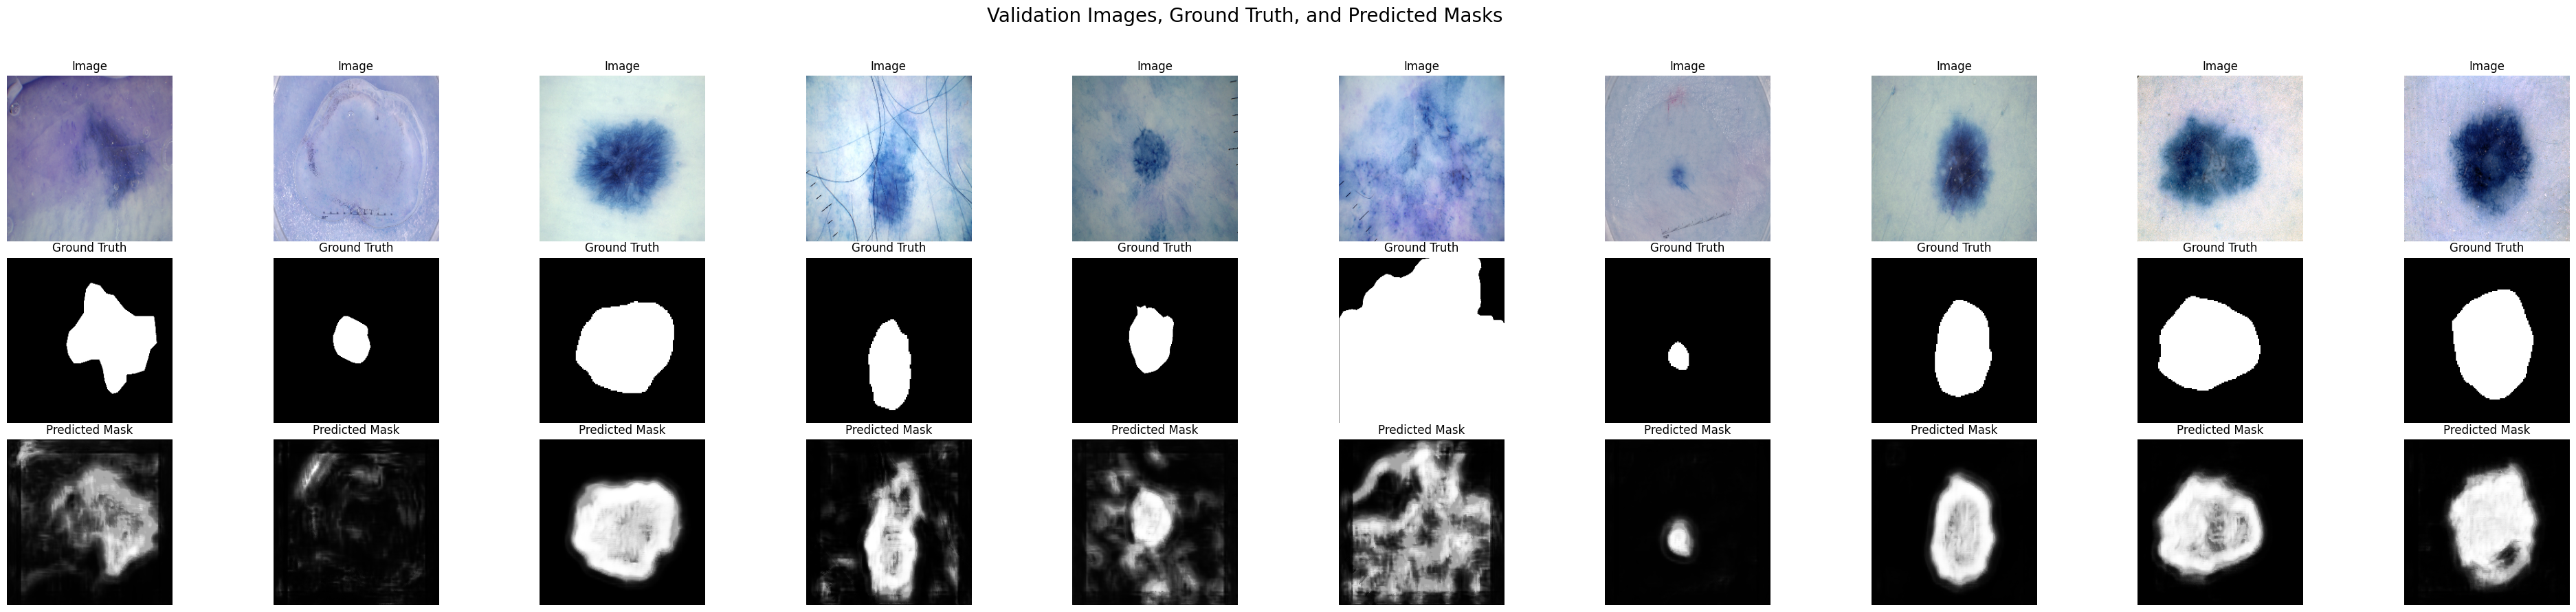

In [10]:
# Function to display original, ground truth mask, and predicted mask
def display_validation_predictions(model, images, true_masks, title=""):
    plt.figure(figsize=(50, 10))
    for i in range(10):
        # Get the predicted mask
        pred_mask = model.predict(np.expand_dims(images[i], axis=0))[0, :, :, 0]

        # Display original image
        plt.subplot(3, 10, i + 1)
        plt.imshow(images[i].astype(np.uint8))
        plt.axis('off')
        plt.title("Image")

        # Display ground truth mask
        plt.subplot(3, 10, i + 11)
        plt.imshow(true_masks[i].squeeze(), cmap='gray')
        plt.axis('off')
        plt.title("Ground Truth")

        # Display predicted mask
        plt.subplot(3, 10, i + 21)
        plt.imshow(pred_mask, cmap='gray')
        plt.axis('off')
        plt.title("Predicted Mask")
    plt.suptitle(title, fontsize=20)
    plt.subplots_adjust(wspace=0.0005, hspace=0.1)
    plt.show()

# Display validation images, ground truth masks, and predicted masks
display_validation_predictions(model_unet, X_val, y_val, title="Validation Images, Ground Truth, and Predicted Masks")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


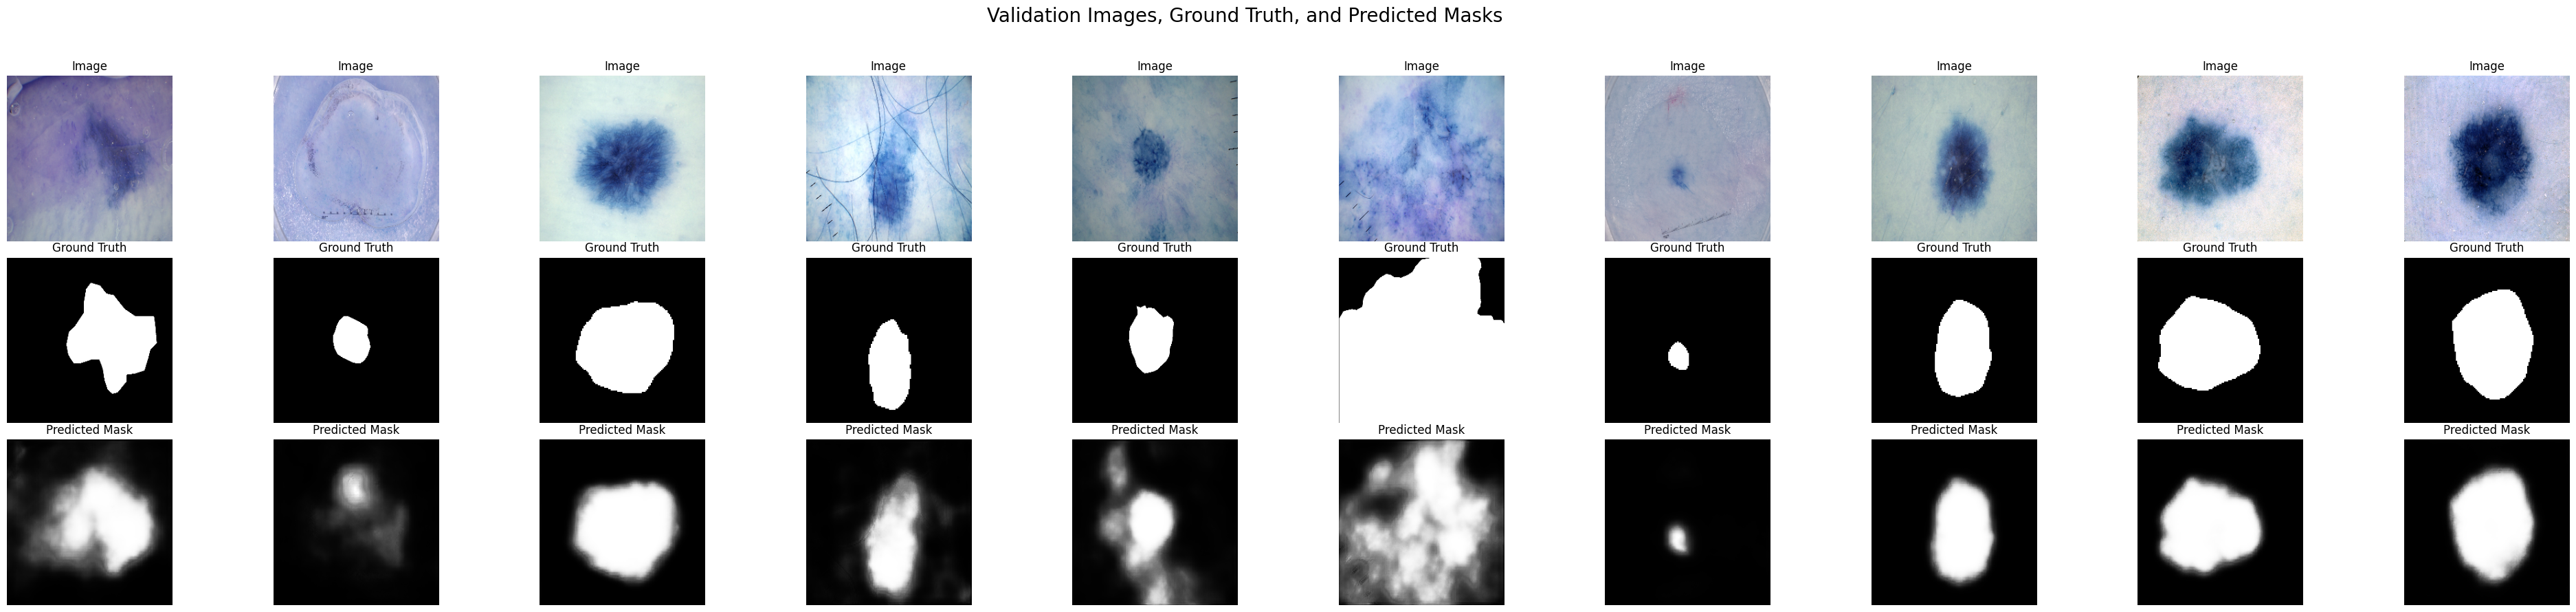

In [ ]:
# Function to display original, ground truth mask, and predicted mask
def display_validation_predictions(model, images, true_masks, title=""):
    plt.figure(figsize=(50, 10))
    for i in range(10):
        # Get the predicted mask
        pred_mask = model.predict(np.expand_dims(images[i], axis=0))[0, :, :, 0]

        # Display original image
        plt.subplot(3, 10, i + 1)
        plt.imshow(images[i].astype(np.uint8))
        plt.axis('off')
        plt.title("Image")

        # Display ground truth mask
        plt.subplot(3, 10, i + 11)
        plt.imshow(true_masks[i].squeeze(), cmap='gray')
        plt.axis('off')
        plt.title("Ground Truth")

        # Display predicted mask
        plt.subplot(3, 10, i + 21)
        plt.imshow(pred_mask, cmap='gray')
        plt.axis('off')
        plt.title("Predicted Mask")
    plt.suptitle(title, fontsize=20)
    plt.subplots_adjust(wspace=0.0005, hspace=0.1)
    plt.show()

# Display validation images, ground truth masks, and predicted masks
display_validation_predictions(model_renet50, X_val, y_val, title="Validation Images, Ground Truth, and Predicted Masks")
